## ECE 520.638 Final Project 
## Team: Chongyu Qu, Daijie Bao, Runtian Tang



## Part 1: Facial Expression Recognition 

In [ ]:
## Mount Google Drive Data 
try:
    from google.colab import drive
    drive.mount('/content/drive')
except:
    print("Mounting Failed.")

Mounted at /content/drive


In [ ]:
## Import external libraries
import numpy as np
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader,Subset,random_split
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import torch.optim as optim
from collections import Counter
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
# Setup the GPU device 
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
pwd

'/content'

## Data preprocess for facial expression recognition 

In [ ]:
## Preprocessing dataset for facial expression recognition
## import data from google drive
train_data_path = '/content/drive/My Drive/DL_final_Project_AffectNet/train_class'
test_data_path = '/content/drive/My Drive/DL_final_Project_AffectNet/val_class'
## parameters for preprocessing 
train_batchsize = 32
val_batchsize = 32
test_batchsize = 32
## data transform 
image_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5241, 0.4233, 0.3762),
                             (0.2880, 0.2604, 0.2550))
    ]),
    "test": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5300, 0.4297, 0.3842),
                             (0.2899, 0.2625, 0.2579))
        ])
}

# Load image data for training and validation 
training_dataset = datasets.ImageFolder(train_data_path, transform = image_transforms["train"])
test_dataset = datasets.ImageFolder(test_data_path, transform = image_transforms["test"])
# Dataloader for training and validation 
# training_dataloader = DataLoader(training_dataset, batch_size=train_batchsize, shuffle=True)
# validation_dataloader = DataLoader(validation_dataset, batch_size = validation_batchsize, shuffle=False)
print(len(training_dataset))
print(len(test_dataset))

15020
4000


In [ ]:
# random select 5000 from training dataset and 2000 from validation dataset
torch.manual_seed(111)
subset_idx = torch.randint(0,len(training_dataset),(2000,))
training_subset = Subset(training_dataset,subset_idx)
train_set,val_set = random_split(training_subset,[1600,400])

In [ ]:
# Dataloader for training and validation 
training_dataloader = DataLoader(train_set, batch_size=train_batchsize, shuffle=True)
validation_dataloader = DataLoader(val_set, batch_size = val_batchsize, shuffle=True)
test_dataloader = DataLoader(test_dataset,batch_size=test_batchsize,shuffle=False)

## Visualize dataset distribution

In [ ]:

dic = training_dataloader.dataset.dataset.dataset.class_to_idx
print(dic)
print(len(dic))
num_class = len(dic)
idx2class = {v: k for k, v in dic.items()}
print(idx2class)

{'anger': 0, 'contempt': 1, 'disgust': 2, 'fear': 3, 'happy': 4, 'neutral': 5, 'sad': 6, 'surprise': 7}
8
{0: 'anger', 1: 'contempt', 2: 'disgust', 3: 'fear', 4: 'happy', 5: 'neutral', 6: 'sad', 7: 'surprise'}


In [ ]:
def find_data_distribution(dataloader,dic):
    targets = []
    for _, target in dataloader:
        target = target.to(device)
        targets.append(target)
    targets = torch.cat(targets)
    dis = targets.unique(return_counts=True)
    count = dict(zip(dic.keys(),dis[1].cpu().numpy()))
    return count

In [ ]:
train_dist=find_data_distribution(training_dataloader,dic)
print(train_dist)

{'anger': 195, 'contempt': 155, 'disgust': 162, 'fear': 208, 'happy': 202, 'neutral': 221, 'sad': 236, 'surprise': 221}


In [ ]:
validation_dist=find_data_distribution(validation_dataloader,dic)
print(validation_dist)

{'anger': 54, 'contempt': 31, 'disgust': 41, 'fear': 50, 'happy': 63, 'neutral': 56, 'sad': 48, 'surprise': 57}


In [ ]:
def visualize_data_distribution(dic,flag):
    plt.figure(figsize=(15,8))
    sns.set_style('darkgrid')
    sns.barplot(data = pd.DataFrame.from_dict([dic]).melt(), x = "variable", y="value", hue="variable")
    plt.title(flag+'set distribution')

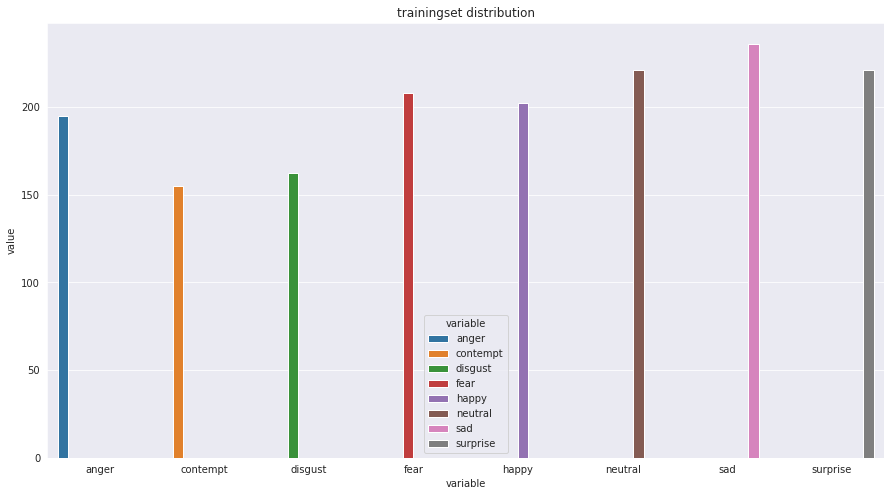

In [ ]:
visualize_data_distribution(train_dist,'training')

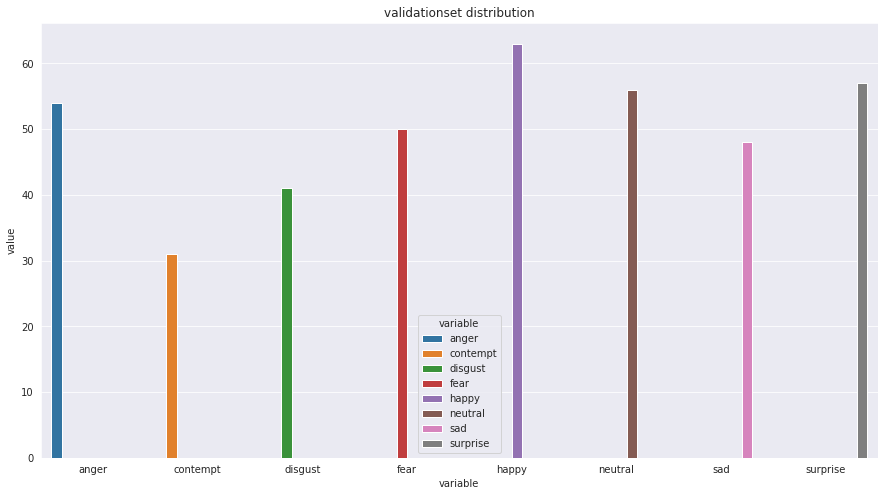

In [ ]:
visualize_data_distribution(validation_dist,'validation')

## Normalize the input data

In [ ]:
## define a function to calculate mean and std of dataset
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        data = data.to(device)
        channels_sum += torch.mean(data, dim=[0,2,3])
        channels_squared_sum += torch.mean(data**2, dim=[0,2,3])
        num_batches += 1  
    mean = channels_sum / num_batches
    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5
    return mean, std

In [ ]:
mean_train,std_train = get_mean_and_std(training_dataloader)
mean_val,std_val = get_mean_and_std(validation_dataloader)
mean_test,std_test = get_mean_and_std(test_dataloader)

In [ ]:
print(mean_train)
print(std_train)
print(mean_val)
print(std_val)
print(mean_test)
print(std_test)

tensor([0.5241, 0.4233, 0.3762], device='cuda:0')
tensor([0.2880, 0.2604, 0.2550], device='cuda:0')
tensor([0.5283, 0.4276, 0.3835], device='cuda:0')
tensor([0.2861, 0.2596, 0.2565], device='cuda:0')
tensor([0.5300, 0.4297, 0.3842], device='cuda:0')
tensor([0.2899, 0.2625, 0.2579], device='cuda:0')


torch.Size([32, 3, 224, 224])


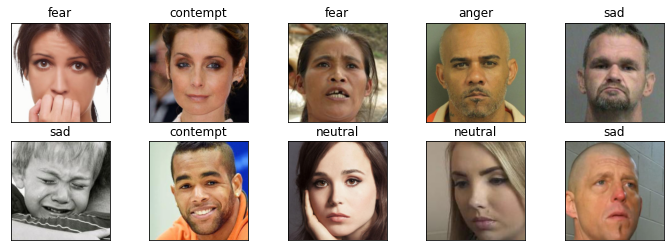

In [ ]:
# visualize image data
mean= torch.tensor([0.5241, 0.4233, 0.3762])
std = torch.tensor([0.2880, 0.2604, 0.2550])
dataiter = iter(training_dataloader)
images,labels = dataiter.next()
print(images.shape)
fig = plt.figure(figsize=(12,4))
for idx in np.arange(10):
    ax = fig.add_subplot(2, 5, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose((images[idx]* std[:, None, None] + mean[:, None, None]),
                            (1,2,0)))
    for key,value in dic.items():
        if value==labels[idx].item():
            ax.set_title(key)
  

## Fine-tune pretrained ResNet18

In [ ]:
## Load pretrained ResNet18 model 
LR = 0.0001
classfication_model_res18 = models.resnet18(pretrained=True)
classfication_model_res18.fc = nn.Linear(512,num_class)
classfication_model_res18.to(device)
Loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classfication_model_res18.parameters(),lr=LR)
print(classfication_model_res18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
## Load pretrained vgg16 model 
LR = 0.0001
classfication_model = models.vgg16(pretrained=True)
classfication_model.classifier[6] = nn.Linear(in_features=4096, out_features=num_class)
classfication_model.to(device)
Loss_criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classfication_model.parameters(),lr=LR)
print(classfication_model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## Model training and validation 

In [ ]:
## Define a fit function for training and validation
num_epochs = 30

def fit(training_load,testing_load,no_epochs,optimizer,model,loss_function):
    history = []
    for epoch in range(no_epochs):
        train_loss,test_loss = 0,0
        correct_train,correct_test = 0,0
        total_train,total_test = 0,0 
        for i, (train_in,train_labels) in enumerate(training_load):
            model.train()
            train_in,train_labels = train_in.to(device),train_labels.to(device)
            optimizer.zero_grad()
            train_out = model(train_in)
            batch_loss_train = loss_function(train_out,train_labels)
            batch_loss_train.backward()
            optimizer.step()
            train_loss += batch_loss_train.item()
            _,predicted_train = torch.max(train_out.data,1)
            total_train += train_labels.size(0)
            correct_train += predicted_train.eq(train_labels).sum().item()

        for i, (test_in,test_labels) in enumerate(testing_load):
            model.eval()
            test_in,test_labels = test_in.to(device),test_labels.to(device)
            test_out = model(test_in)
            _,predicted_test = torch.max(test_out.data,1)
            batch_loss_test = loss_function(test_out,test_labels)
            test_loss += batch_loss_test.item()
            total_test += test_labels.size(0)
            correct_test += predicted_test.eq(test_labels).sum().item()

        total_train_loss = train_loss/len(training_load)
        train_accu = 100.*correct_train/total_train
        total_test_loss = test_loss/len(testing_load)
        test_acc = 100.*correct_test/total_test
        print(f"Epoch [{epoch + 1}/{no_epochs}] => train_loss:{total_train_loss}, train_accuracy:{train_accu},val_loss: {total_test_loss},val_accuracy:{test_acc}")
        history.append({"train_loss": total_train_loss,
                        "train_accuracy": train_accu,
                        "val_loss": total_test_loss,
                        "val_accuracy":test_acc,
                        })
    return history

In [ ]:
classfication_his = fit(training_dataloader,validation_dataloader,num_epochs,optimizer,classfication_model,Loss_criterion)

Epoch [1/20] => train_loss:2.047093014717102, train_accuracy:17.0625,val_loss: 2.0082832941642175,val_accuracy:18.25
Epoch [2/20] => train_loss:1.8495577263832093, train_accuracy:25.9375,val_loss: 1.8198012572068434,val_accuracy:30.75
Epoch [3/20] => train_loss:1.6438704824447632, train_accuracy:36.875,val_loss: 1.6902246750318086,val_accuracy:36.0
Epoch [4/20] => train_loss:1.2746568524837494, train_accuracy:52.0,val_loss: 1.719423532485962,val_accuracy:41.0
Epoch [5/20] => train_loss:0.82474191904068, train_accuracy:69.8125,val_loss: 1.7442717185387244,val_accuracy:43.25
Epoch [6/20] => train_loss:0.3562397664785385, train_accuracy:87.5625,val_loss: 2.159998517770034,val_accuracy:43.0
Epoch [7/20] => train_loss:0.2526423986256123, train_accuracy:92.0,val_loss: 2.4171278660113993,val_accuracy:46.5
Epoch [8/20] => train_loss:0.19329223226755857, train_accuracy:93.5,val_loss: 2.6939764573023868,val_accuracy:45.0
Epoch [9/20] => train_loss:0.09468423849903047, train_accuracy:97.125,val_l

In [ ]:
classfication_his_res18 = fit(training_dataloader,validation_dataloader,num_epochs,optimizer,classfication_model_res18,Loss_criterion)

Epoch [1/30] => train_loss:1.8680869078636169, train_accuracy:29.0625,val_loss: 1.6104909456693208,val_accuracy:40.0
Epoch [2/30] => train_loss:0.877301173210144, train_accuracy:79.125,val_loss: 1.4999662270912757,val_accuracy:47.75
Epoch [3/30] => train_loss:0.30135668128728865, train_accuracy:97.875,val_loss: 1.5073781105188222,val_accuracy:46.5
Epoch [4/30] => train_loss:0.08790681272745132, train_accuracy:99.9375,val_loss: 1.5366620925756602,val_accuracy:47.5
Epoch [5/30] => train_loss:0.035514001883566376, train_accuracy:100.0,val_loss: 1.5461194606927724,val_accuracy:48.0
Epoch [6/30] => train_loss:0.021963351499289276, train_accuracy:99.9375,val_loss: 1.5545878410339355,val_accuracy:48.25
Epoch [7/30] => train_loss:0.01750628534704447, train_accuracy:99.9375,val_loss: 1.5277891984352698,val_accuracy:47.5
Epoch [8/30] => train_loss:0.012432478833943605, train_accuracy:99.9375,val_loss: 1.5816616278428297,val_accuracy:48.25
Epoch [9/30] => train_loss:0.008589360313490033, train_ac

In [ ]:
torch.save(classfication_model.state_dict(), '/content/drive/My Drive/model_demo/classifier.pth')


In [ ]:
def visualize_loss(his,num_epochs):
    train_loss = []
    validation_loss = []
    for x in his:
        train_loss.append(x["train_loss"])
        validation_loss.append(x["val_loss"])
    epochs = np.arange(num_epochs)
    sns.set_style('darkgrid')
    plt.plot(epochs, train_loss)
    plt.plot(epochs, validation_loss)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss of training and validation over epochs")
    plt.legend(["training", "validation"])
    plt.show()

In [ ]:
def visualize_accuracy(his,num_epochs):
    train_accu = []
    validation_accu = []
    for x in his:
        train_accu.append(x["train_accuracy"])
        validation_accu.append(x["val_accuracy"])
    epochs = np.arange(num_epochs)
    sns.set_style('darkgrid')
    plt.plot(epochs, train_accu)
    plt.plot(epochs, validation_accu)
    plt.xlabel("Epochs")
    plt.ylabel("accuracy")
    plt.title("accuracy of training and validation over epochs")
    plt.legend(["training", "validation"])
    plt.show()

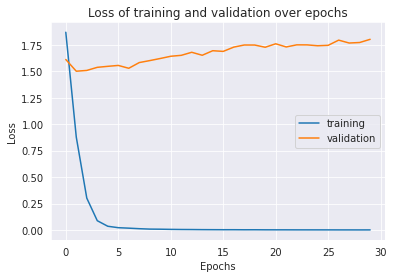

In [ ]:
visualize_loss(classfication_his_res18,num_epochs)

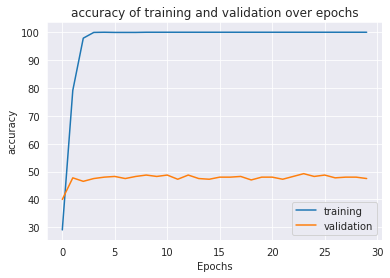

In [ ]:
visualize_accuracy(classfication_his_res18,num_epochs)

In [ ]:
with torch.no_grad():
    true_labels = []
    pred_labels= []
    for i, (img,labels) in enumerate(test_dataloader):
        img,labels = img.to(device),labels.to(device)
        output = classfication_model_res18(img)
        _,pred = torch.max(output,1)
        true_labels.append(labels)
        pred_labels.append(pred)
    true_labels = torch.cat(true_labels)
    pred_labels = torch.cat(pred_labels)


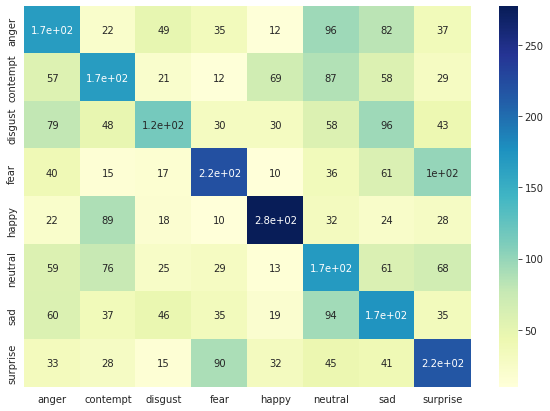

In [ ]:
cf_matrix = confusion_matrix(true_labels.cpu().numpy(),pred_labels.cpu().numpy())
df_cm = pd.DataFrame(cf_matrix, index = [i for i in dic.keys()],
                  columns = [i for i in dic.keys()])
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True,cmap="YlGnBu")

## Part 2: Face detection with MTCNN

In [ ]:
## Install MTCNN Package 
! pip install mtcnn

In [ ]:
## Import external libraries for face detection 
import mtcnn
from mtcnn.mtcnn import MTCNN
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

In [ ]:
matplotlib.rc_file_defaults()

In [ ]:
# load image from file
image_path = '/content/drive/MyDrive/model_demo/waitress.jpg'


In [ ]:
## MTCNN Face detector
def face_detector(image):
    image_pixels = plt.imread(image)
    detector = MTCNN()
    detection_coordinate = detector.detect_faces(image_pixels)
    print('The key detection coordinates are ', detection_coordinate)
    return detection_coordinate

In [ ]:
## Get face detection result
detection_coordinate_set = face_detector(image_path)

The key detection coordinates are  [{'box': [278, 155, 62, 85], 'confidence': 0.999333918094635, 'keypoints': {'left_eye': (297, 191), 'right_eye': (325, 182), 'nose': (320, 205), 'mouth_left': (301, 217), 'mouth_right': (333, 210)}}, {'box': [287, 234, 51, 67], 'confidence': 0.8218860626220703, 'keypoints': {'left_eye': (312, 262), 'right_eye': (329, 267), 'nose': (322, 279), 'mouth_left': (309, 288), 'mouth_right': (321, 292)}}]


In [ ]:
## Create a bounding box for detection result
def bounding_box_creator(image_path, coordinate_set,new_path):
    data = plt.imread(image_path)
    plt.imshow(data)
    ax = plt.gca()
    for coordinate in coordinate_set:
        x, y, width, height = coordinate['box']
        rect = plt.Rectangle((x, y), width, height, fill=False, color='red')
        ax.add_patch(rect)
    plt.savefig(new_path)
    plt.show()

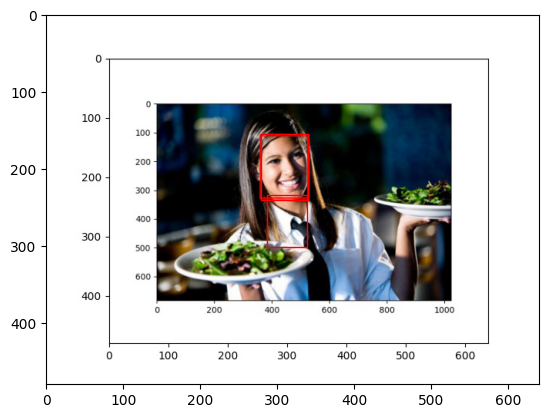

In [ ]:
## Print out Face detection result 
bounding_box_creator(image_path, detection_coordinate_set,'/content/drive/MyDrive/model_demo/waitress_new.jpg')

Personal data testing

In [ ]:
trent_path = '/content/drive/MyDrive/model_demo/happy.JPG'

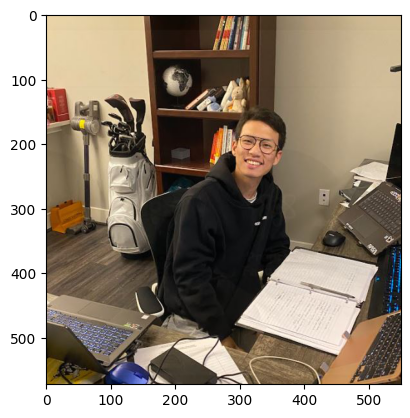

In [ ]:
data = plt.imread(trent_path)
plt.imshow(data)
plt.show()

In [ ]:
detection_coordinate_set_trent = face_detector(trent_path)

The key detection coordinates are  [{'box': [295, 165, 62, 85], 'confidence': 0.999992847442627, 'keypoints': {'left_eye': (313, 197), 'right_eye': (341, 202), 'nose': (323, 214), 'mouth_left': (307, 226), 'mouth_right': (335, 231)}}]


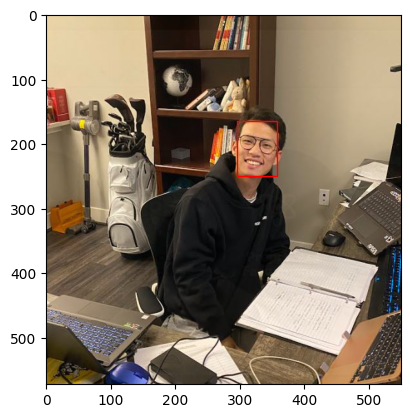

In [ ]:
bounding_box_creator(trent_path, detection_coordinate_set_trent,'/content/drive/MyDrive/model_demo/trent_happy.jpg')

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/functional.py:133: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:178.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


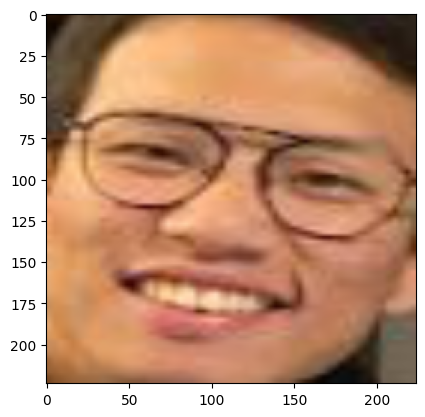

In [ ]:
face = data[165: 165+85,295:295+62]

convert_tensor = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])
face_input = convert_tensor(face)

plt.imshow(np.transpose(face_input,(1,2,0)))
plt.savefig('/content/drive/MyDrive/model_demo/trent_croped.jpg')

plt.show()


In [ ]:
trent_mean = torch.mean(face_input, dim=[1,2])
trent_std = torch.std(face_input,dim=[1,2])

In [ ]:
print(trent_mean)
print(trent_std)

tensor([0.7124, 0.4947, 0.3603])
tensor([0.2077, 0.1589, 0.1251])


In [ ]:
face_input_norm=(face_input-trent_mean[:, None, None])/trent_std[:, None, None]

In [ ]:
state_dic=torch.load('/content/drive/MyDrive/model_demo/classifier.pth')

In [ ]:
classfication_model.load_state_dict(state_dic)

<All keys matched successfully>

In [ ]:
with torch.no_grad():
    out = classfication_model(face_input_norm.to(device).unsqueeze(0))
    _,predicted_label = torch.max(out.data,1)

In [ ]:
idx2class[predicted_label.cpu().item()]

'anger'